In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import random
import shutil

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb

from tqdm import tqdm

import skimage.io
import skimage.segmentation
import skimage.morphology

import sys
__file__ = 'full_experiment.ipynb'
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))

import utils.dirtools  # utils package should has __init__.py in it
import utils.augmentation
import utils.model_builder
import utils.data_provider
import utils.metrics
import utils.objectives
import utils.evaluation

import keras.backend
import keras.callbacks
import keras.layers
import keras.models
import keras.optimizers
import tensorflow as tf

from config import config_vars

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

def empty_dir(folder):
    print('empty directory: ', folder)
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path): shutil.rmtree(file_path)
        except Exception as e:
            print(e)

os.environ["CUDA_VISIBLE_DEVICES"] = "3"

# build session running on GPU 1
configuration = tf.ConfigProto()
configuration.gpu_options.allow_growth = True
# configuration.gpu_options.visible_device_list = "0, 1"
session = tf.Session(config = configuration)

# apply session
keras.backend.set_session(session)

Using TensorFlow backend.


In [2]:
config_vars["root_directory"] = 'DATA/FISH/'
experiment_name = '12'

config_vars = utils.dirtools.setup_working_directories(config_vars)
config_vars = utils.dirtools.setup_experiment(config_vars, experiment_name)
os.makedirs(config_vars["normalized_images_dir"], exist_ok=True)
os.makedirs(config_vars["boundary_labels_dir"], exist_ok=True)

config_vars["no_boundary_labels_dir"] = 'DATA/FISH/no_boundary_labels/'
os.makedirs(config_vars["no_boundary_labels_dir"], exist_ok=True)

In [3]:
config_vars

{'root_directory': 'DATA/FISH/',
 'pixel_depth': 8,
 'min_nucleus_size': 25,
 'boundary_size': 2,
 'learning_rate': 0.0001,
 'epochs': 200,
 'steps_per_epoch': 300,
 'batch_size': 16,
 'val_batch_size': 16,
 'rescale_labels': True,
 'crop_size': 256,
 'cell_min_size': 16,
 'boundary_boost_factor': 1,
 'object_dilation': 3,
 'raw_images_dir': 'DATA/FISH/raw_images/',
 'raw_annotations_dir': 'DATA/FISH/raw_annotations/',
 'normalized_images_dir': 'DATA/FISH/norm_images/',
 'boundary_labels_dir': 'DATA/FISH/boundary_labels/',
 'experiment_dir': 'DATA/FISH/experiments/12/out/',
 'probmap_out_dir': 'DATA/FISH/experiments/12/out/prob/',
 'labels_out_dir': 'DATA/FISH/experiments/12/out/segm/',
 'path_files_training': 'DATA/FISH/experiments/12/training.txt',
 'path_files_validation': 'DATA/FISH/experiments/12/validation.txt',
 'path_files_test': 'DATA/FISH/experiments/12/test.txt',
 'model_file': 'DATA/FISH/experiments/12/model.hdf5',
 'csv_log_file': 'DATA/FISH/experiments/12/log.csv',
 'no_b

### PREPROCESS

Text(0.5, 1.0, 'histogram')

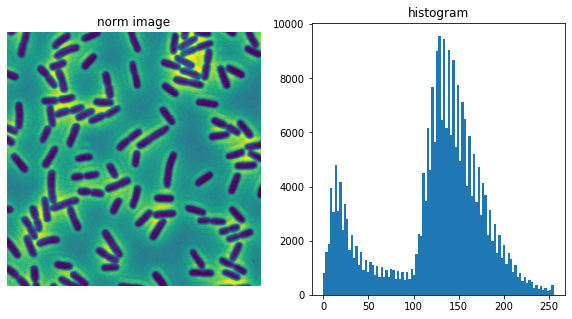

In [13]:
# use hist gram to show pixel value distribution

img = skimage.io.imread(config_vars["normalized_images_dir"] + '0010.png')

figure, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img)
ax[0].set_title('norm image')
ax[0].axis('off')
ax[1].hist(img.flatten(), bins=100)[2]
ax[1].set_title('histogram')
# ax[1].axis('off')

--------------------------------

In [11]:
"""This is only for LineageTracking Setup

'path_files_training': 'DATA/LineageTracking/training.txt',
'path_files_validation': 'DATA/LineageTracking/validation.txt',
'path_files_test': 'DATA/LineageTracking/test.txt',

folder 001 - 095 total 1585 images, 16.68 for one folder
setup dirs: `normalized` and `boundary label`
img list should contain file names like 001/0000.tif

"""  

fd_list = sorted(os.listdir('DATA/LineageTracking/raw_images/'))
# makedirs for 001, 002, ...
for f in fd_list:
    os.makedirs(config_vars["normalized_images_dir"] + f, exist_ok=True)
    os.makedirs(config_vars["boundary_labels_dir"] + f, exist_ok=True)   

# get these two lists for pre-process on all data
img_list = []
for f in fd_list:
    tmp_list = os.listdir('DATA/LineageTracking/raw_images/' + f)
    tmp_list = [x for x in tmp_list if x.endswith('tif')]
    for img in sorted(tmp_list):
        img_list.append(f + '/' + img)

mask_list = []
for f in fd_list:
    tmp_list = os.listdir('DATA/LineageTracking/raw_annotations/' + f)
    tmp_list = [x for x in tmp_list if x.endswith('png')]
    for mask in sorted(tmp_list):
        mask_list.append(f + '/' + mask)  

In [12]:
# normalize images

# filelist = sorted(os.listdir(config_vars["raw_images_dir"]))
filelist = img_list  # Lineage Tracking has second order directory

def normalize_original_img(filelist):
    for filename in tqdm(filelist):
        # load image and its annotation
        orig_img = skimage.io.imread(config_vars["raw_images_dir"] + filename)       
        # normalize to [0,1]
        percentile = 99.9
        high = np.percentile(orig_img, percentile)  # maximum for all image
        low = np.percentile(orig_img, 100-percentile)

        img = np.minimum(high, orig_img)
        img = np.maximum(low, img)

        # gives float64, thus cast to 8 bit later
        img = (img - low) / (high - low) 
        img = skimage.img_as_ubyte(img) 

        skimage.io.imsave(config_vars["normalized_images_dir"] + filename[:-3] + 'png', img)    

normalize_original_img(filelist)

  0%|          | 0/1585 [00:00<?, ?it/s]/home/lanbowen23/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
100%|██████████| 1585/1585 [00:51<00:00, 30.66it/s]


In [6]:
# segmentation to boundary

filelist = sorted(os.listdir(config_vars["raw_annotations_dir"]))
filelist = [x for x in filelist if x.endswith('png')]
# filelist = mask_list

def segment_to_label(filelist, total_objects = 0):
    for filename in tqdm(filelist):
        annot = skimage.io.imread(config_vars["raw_annotations_dir"] + filename)
        annot = skimage.morphology.label(annot)
        total_objects += len(np.unique(annot)) - 1
        annot = skimage.morphology.remove_small_objects(annot, min_size=config_vars["min_nucleus_size"])
        # find boundaries
        boundaries = skimage.segmentation.find_boundaries(annot)
        for k in range(2, config_vars["boundary_size"], 2):
            boundaries = skimage.morphology.binary_dilation(boundaries)

        # 3-CHANNEL BINARY LABEL
        # prepare buffer for binary label
        label_binary = np.zeros((annot.shape + (3,))) 
        label_binary[(annot == 0) & (boundaries == 0), 0] = 1  # bg
        label_binary[(annot != 0) & (boundaries == 0), 1] = 1  # cell
        label_binary[boundaries == 1, 2] = 1  # boundary
        # Convert an image to unsigned byte format, with values in [0, 255]
        label_binary = skimage.img_as_ubyte(label_binary)
        skimage.io.imsave(config_vars["boundary_labels_dir"] + filename, label_binary)
    print("Total objects: ",total_objects)
    
segment_to_label(filelist)

  0%|          | 0/339 [00:00<?, ?it/s]/home/lanbowen23/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
100%|██████████| 339/339 [00:55<00:00,  6.78it/s]


Total objects:  22162


In [3]:
# segmentation to 0/1 label (no boundary channel)

filelist = sorted(os.listdir(config_vars["raw_annotations_dir"]))
filelist = [x for x in filelist if x.endswith('png')]

def segment_to_label(filelist, total_objects = 0):
    for filename in tqdm(filelist):
        annot = skimage.io.imread(config_vars["raw_annotations_dir"] + filename)
        annot = skimage.morphology.label(annot)
        total_objects += len(np.unique(annot)) - 1
        # filter small objects, e.g. micro nulcei
        annot = skimage.morphology.remove_small_objects(annot, min_size=config_vars["min_nucleus_size"])

        # use one channel to save 2 classes label
        label_binary = np.zeros((annot.shape)) 
        label_binary[(annot == 0)] = 0  # bg
        label_binary[(annot !=  0)] = 1  # cell
        # Convert an image to unsigned byte format, with values in [0, 255]
        label_binary = skimage.img_as_ubyte(label_binary)
        skimage.io.imsave(config_vars["no_boundary_labels_dir"] + filename, label_binary)
    print("Total objects: ",total_objects)
    
segment_to_label(filelist)

  0%|          | 0/339 [00:00<?, ?it/s]/home/lanbowen23/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
100%|██████████| 339/339 [00:21<00:00, 16.06it/s]

Total objects:  22162


### TRAIN

#### Set Up Datasets

In [4]:
file_list = os.listdir(config_vars["normalized_images_dir"])
image_list = [x for x in file_list if x.endswith("png")]
len(image_list)

339

In [5]:
# set up train-valid split 
def create_image_lists(dir_raw_images):
    file_list = os.listdir(dir_raw_images)
    image_list = [x for x in file_list if x.endswith("png")]
    image_list = sorted(image_list)

    image_list_train_aug = []
    image_list_test = []
#     image_list_train = []
#     image_list_validation = image_list
    
    image_list_validation = image_list[:48]
    image_list_2 = image_list[48:]
    random.shuffle(image_list_2)
    image_list_train = image_list_2
    return image_list_train, image_list_test, image_list_validation, image_list_train_aug

[list_training, list_test, list_validation, list_training_aug] = create_image_lists(
    config_vars["normalized_images_dir"],
#         config_vars["training_fraction"],
#         config_vars["validation_fraction"]
)

# write list into txt file
utils.dirtools.write_path_files(config_vars["path_files_training"], list_training)
utils.dirtools.write_path_files(config_vars["path_files_validation"], list_validation)
utils.dirtools.write_path_files(config_vars["path_files_test"], list_test)

In [14]:
"""Only for LineageTracking Setup
split train, valid, test (image name list)

"""
train_fd_list = fd_list[:60]
valid_fd_list = fd_list[60:]

# boundary_labels_gai是清洗过后的labels所在的文件夹
list_train = []
for f in train_fd_list:
    tmp_list = os.listdir('DATA/LineageTracking/boundary_labels_gai/' + f)
    tmp_list = [x for x in tmp_list if x.endswith('png')]
    for e in sorted(tmp_list):
        list_train.append(f + '/' + e)
        
list_valid = []
for f in valid_fd_list:
    tmp_list = os.listdir('DATA/LineageTracking/boundary_labels/' + f)
    tmp_list = [x for x in tmp_list if x.endswith('png')]
    for e in sorted(tmp_list):
        list_valid.append(f + '/' + e)
        
list_test = []


utils.dirtools.write_path_files(config_vars["path_files_training"], list_train)
utils.dirtools.write_path_files(config_vars["path_files_validation"], list_valid)
utils.dirtools.write_path_files(config_vars["path_files_test"], list_test)

##### data generator

In [6]:
# read txt file into dict partitions with 3 list for train/valid/test
data_partitions = utils.dirtools.read_data_partitions(config_vars, load_augmented=False)

In [7]:
# setup data-generator
train_gen = utils.data_provider.random_sample_generator(
    config_vars["normalized_images_dir"],
    config_vars["no_boundary_labels_dir"],
    data_partitions["training"],
    config_vars["batch_size"],
    config_vars["pixel_depth"],
    config_vars["crop_size"],
    config_vars["crop_size"],
    config_vars["rescale_labels"]
)

val_gen = utils.data_provider.single_data_from_images(
     config_vars["normalized_images_dir"],
     config_vars["no_boundary_labels_dir"],
     data_partitions["validation"],
     config_vars["val_batch_size"],
     config_vars["pixel_depth"],
     config_vars["crop_size"],
     config_vars["crop_size"],
     config_vars["rescale_labels"]
)

In [12]:
train_iter = iter(train_gen)
a = next(train_iter)
len(a[0])

10

### Grid Show A Set of Pictures

In [2]:
images = np.zeros((6, 1, 512, 512))
img_list = sorted(glob.glob('DATA/LineageTracking/norm_images/001/*.png'))
for i, im in enumerate(img_list[8:]):
    img = skimage.io.imread(im)
    images[i, 0] = img.squeeze()
    if i == 5:
        break

(6, 1, 512, 512) 0.0 1.0


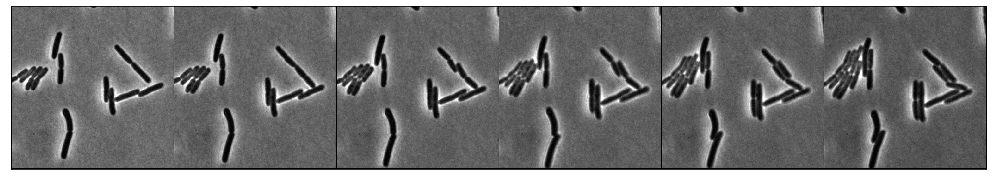

In [3]:
import torch
import torchvision
# show images
images = images/255
print(images.shape, images.min(), images.max())
images = torch.tensor(images)
image = torchvision.utils.make_grid(images, nrow=6)
plt.figure(figsize = (24, 3))
plt.xticks([])
plt.yticks([])
plt.imshow(np.transpose(image.numpy(), (1,2,0)))

# def imshow(img):
# #     img = img / 2 + 0.5     # unnormalize
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))

# # show images
# print(images.shape)
# imshow(torchvision.utils.make_grid(images, nrow=8))